# Gender, Age, and Expression Prediction

In [1]:
# imports
import os
import random
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import files
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import load_img
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Rescaling, BatchNormalization, Activation

In [2]:
! pip install -q kaggle

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dikyrestumaulana","key":"017aefb04593828d441ea9ffa7305c0a"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! mkdir datasets

In [5]:
! kaggle datasets download -d jangedoo/utkface-new

 99% 328M/331M [00:17<00:00, 22.5MB/s]
100% 331M/331M [00:17<00:00, 20.1MB/s]


In [6]:
! kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 99% 119M/121M [00:06<00:00, 25.6MB/s]
100% 121M/121M [00:06<00:00, 19.6MB/s]


In [7]:
! mkdir datasets/agender
! unzip "utkface-new.zip" -d datasets/agender

Streaming output truncated to the last 5000 lines.
  inflating: datasets/agender/utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: datasets/agender/utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: datasets/agender/utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: datasets/agender/utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: datasets/agender/utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: datasets/agender/utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: datasets/agender/utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: datasets/agender/utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: datasets/agender/utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  in

In [8]:
! mkdir datasets/expression
! unzip "face-expression-recognition-dataset.zip" -d datasets/expression

Streaming output truncated to the last 5000 lines.
  inflating: datasets/expression/images/validation/fear/8797.jpg  
  inflating: datasets/expression/images/validation/fear/8818.jpg  
  inflating: datasets/expression/images/validation/fear/886.jpg  
  inflating: datasets/expression/images/validation/fear/9037.jpg  
  inflating: datasets/expression/images/validation/fear/9040.jpg  
  inflating: datasets/expression/images/validation/fear/9101.jpg  
  inflating: datasets/expression/images/validation/fear/911.jpg  
  inflating: datasets/expression/images/validation/fear/9179.jpg  
  inflating: datasets/expression/images/validation/fear/9205.jpg  
  inflating: datasets/expression/images/validation/fear/9232.jpg  
  inflating: datasets/expression/images/validation/fear/9251.jpg  
  inflating: datasets/expression/images/validation/fear/9261.jpg  
  inflating: datasets/expression/images/validation/fear/9281.jpg  
  inflating: datasets/expression/images/validation/fear/9302.jpg  
  inflating: 

# CNN

## Gender and Age

In [20]:
BASE_DIR = 'datasets/agender/UTKFace'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in image_filenames:
    image_path = os.path.join(BASE_DIR, image)
    img_components = image.split('_')
    age_label = int(img_components[0])
    gender_label = int(img_components[1])

    # Append the image_path, age_label, and gender_label
    age_labels.append(age_label)
    gender_labels.append(gender_label)
    image_paths.append(image_path)

In [21]:
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels

In [22]:
# Define the age categories
bins = [0, 18, 30, 50, float('inf')]
labels = ['<18', '18-30', '30-50', '50+']

# Create a new column with the age categories
df['age'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

In [23]:
df.shape

(23708, 3)

In [24]:
df.head(10)

,image_path,age,gender
0,datasets/agender/UTKFace/22_1_3_20170104222214...,18-30,1
1,datasets/agender/UTKFace/29_0_1_20170116142845...,18-30,0
2,datasets/agender/UTKFace/45_1_1_20170113195612...,30-50,1
3,datasets/agender/UTKFace/24_1_0_20170117150911...,18-30,1
4,datasets/agender/UTKFace/23_1_2_20170116173016...,18-30,1
5,datasets/agender/UTKFace/27_1_2_20170116185938...,18-30,1
6,datasets/agender/UTKFace/18_1_0_20170103201359...,18-30,1
7,datasets/agender/UTKFace/20_0_1_20170116204110...,18-30,0
8,datasets/agender/UTKFace/41_0_1_20170113134000...,30-50,0
9,datasets/agender/UTKFace/15_1_4_20170103233356...,<18,1


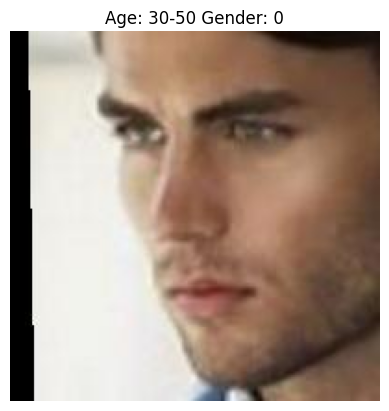

In [25]:
# Show one random image data
rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
img = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender}')
plt.axis('off')
plt.imshow(img)
plt.show()

In [26]:
mapping = {'<18':0 , '18-30':1, '30-50':2 , '50+':3}
df['age'] = df['age'].map(mapping)

In [27]:
def extract_image_features(images):
    features = list()

    for image in images:
        img = load_img(image, color_mode='grayscale')
        img = img.resize((56, 56), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 56, 56, 1)
    return features

In [28]:
# Features vector for gender and age
X_agender = extract_image_features(df['image_path'])
X_agender = X_agender/255.

In [29]:
# Labels for gender and age
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [30]:
# Split data into training and validation set
train_portion = 0.8
train_size = int(len(X_agender) * train_portion)

X_agender_train = X_agender[:train_size]
X_agender_test = X_agender[train_size:]

y_gender_train = y_gender[:train_size]
y_gender_test = y_gender[train_size:]

y_age_train = y_age[:train_size]
y_age_test = y_age[train_size:]

In [22]:
def create_agender_cnn_model():
    model = Sequential()
    model.add(Input((56, 56, 1)))

    # Convolutional layer
    model.add(Conv2D(16, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())

    # Dropout layer to prevent overfitting
    model.add(Dropout(0.5))

    # Flatten the feature maps
    model.add(Flatten())

    # Dense (fully connected) layers
    model.add(Dense(128, activation='relu'))

    # Separate output layers for gender and age predictions
    output_1 = Dense(1, activation='sigmoid', name='gender_out')(model.output)
    output_2 = Dense(1, activation='relu', name='age_out')(model.output)

    # Define the model with multiple outputs
    model = Model(inputs=model.input, outputs=[output_1, output_2])

    # Compile the model
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
# Create gender and age CNN model
agender_cnn_model = create_agender_cnn_model()

# Set checkpoint based on the best val_accuracy
checkpoint = ModelCheckpoint("agender_cnn_model.keras", monitor='val_age_out_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint]

# Training
history = agender_cnn_model.fit(X_agender_train,
                            y=[y_gender_train, y_age_train],
                            batch_size=32,
                            epochs=50,
                            validation_data=(X_agender_test, [y_gender_test, y_age_test]),
                            callbacks=callbacks)

## Expression

In [48]:
TRAIN_DIR = 'datasets/expression/images/train/'
VAL_DIR = 'datasets/expression/images/validation/'

train_datagen = ImageDataGenerator(rescale=1./255.,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=128,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=False,
    target_size=(56, 56)
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    batch_size=128,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=False,
    target_size=(56, 56)
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [32]:
def create_expression_cnn_model():
    # Initialising the CNN
    model = Sequential()
    model.add(Input((56, 56, 1)))

    # 1 - Convolution
    model.add(Conv2D(64,(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 2nd Convolution layer
    model.add(Conv2D(128,(5,5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 3rd Convolution layer
    model.add(Conv2D(512,(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 4th Convolution layer
    model.add(Conv2D(512,(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flattening
    model.add(Flatten())

    # Fully connected layer 1st layer
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    # Fully connected layer 2nd layer
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(7, activation='softmax'))

    model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

    return model

In [ ]:
# Create expression CNN model
expression_cnn_model = create_expression_cnn_model()

# Set checkpoint based on the best val_accuracy
checkpoint = ModelCheckpoint("expression_cnn_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint]

# Training
history = expression_cnn_model.fit(train_generator,
                               epochs=50,
                               verbose=1,
                               validation_data=val_generator,
                               callbacks=callbacks)

Epoch 1/50
226/226 [==============================] - ETA: 0s - loss: 1.8963 - accuracy: 0.2516
Epoch 1: val_accuracy improved from -inf to 0.17209, saving model to expression_model.keras
226/226 [==============================] - 43s 145ms/step - loss: 1.8963 - accuracy: 0.2516 - val_loss: 1.8516 - val_accuracy: 0.1721
Epoch 2/50
226/226 [==============================] - ETA: 0s - loss: 1.6466 - accuracy: 0.3528
Epoch 2: val_accuracy improved from 0.17209 to 0.31758, saving model to expression_model.keras
226/226 [==============================] - 34s 151ms/step - loss: 1.6466 - accuracy: 0.3528 - val_loss: 1.8430 - val_accuracy: 0.3176
Epoch 3/50
226/226 [==============================] - ETA: 0s - loss: 1.4734 - accuracy: 0.4305
Epoch 3: val_accuracy improved from 0.31758 to 0.42966, saving model to expression_model.keras
226/226 [==============================] - 32s 143ms/step - loss: 1.4734 - accuracy: 0.4305 - val_loss: 1.5296 - val_accuracy: 0.4297
Epoch 4/50
226/226 [========

## Prediction

In [ ]:
# Load gender and age CNN model
agender_cnn_model = load_model("models/agender_cnn_model.keras")

In [ ]:
# Load expression CNN model
expression_cnn_model = load_model("models/expression_cnn_model.keras")

1/1 [==============================] - 0s 26ms/step


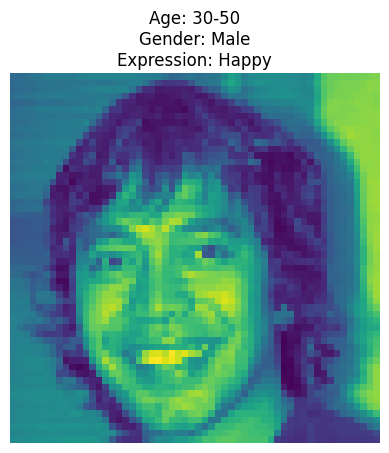

In [ ]:
local_image_path = 'komeng_56.jpg'

# Labels
gender_labels = ['Male', 'Female']
age_labels = ['<18', '18-30', '30-50', '50+']
expression_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Make predictions for the local image
img = load_img(local_image_path, target_size=(56, 56), color_mode='grayscale')  # Adjust target_size as needed
img_array = img.resize((56, 56), Image.Resampling.LANCZOS)
img_array = np.array(img_array)
img_array = img_array.reshape(1, 56, 56, 1)
img_array = img_array/255.

# Predict gender and age
gender_pred, age_pred = agender_cnn_model.predict(img_array)
gender_pred = gender_labels[round(gender_pred[0][0])]
age_pred = age_labels[round(age_pred[0][0])]

# Predict expression
expression_pred = expression_cnn_model.predict(img_array)
expression_pred = expression_labels[np.argmax(expression_pred)]

plt.title(f'Age: {age_pred}\nGender: {gender_pred}\nExpression: {expression_pred}')
plt.axis('off')
plt.imshow(img)
plt.show()

## Evaluation

In [36]:
# Get gender and age predictions
gender_train_pred, age_train_pred = agender_cnn_model.predict(X_agender_train, verbose=0)
gender_test_pred, age_test_pred = agender_cnn_model.predict(X_agender_test, verbose=0)

In [37]:
gender_train_pred = gender_train_pred.round().flatten()
age_train_pred = age_train_pred.round().flatten()
gender_test_pred = gender_test_pred.round().flatten()
age_test_pred = age_test_pred.round().flatten()

In [49]:
# Get expression predictions
expression_train_pred = expression_cnn_model.predict(train_generator, verbose=0)
expression_test_pred = expression_cnn_model.predict(val_generator, verbose=0)

In [50]:
expression_train_pred = expression_train_pred.argmax(axis=1)
expression_test_pred = expression_test_pred.argmax(axis=1)

In [40]:
def print_report(name, y_train, y_train_pred, y_test, y_test_pred, multiclass=False):
    print("-----", name, "-----")
    print("Training set")
    print("Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Precision:", precision_score(y_train, y_train_pred, average="micro" if multiclass else "binary"))
    print("Recall:", recall_score(y_train, y_train_pred, average="micro" if multiclass else "binary"))
    print("F1-score:", f1_score(y_train, y_train_pred, average="micro" if multiclass else "binary"))
    print("Validation set")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Precision:", precision_score(y_test, y_test_pred, average="micro" if multiclass else "binary"))
    print("Recall:", recall_score(y_test, y_test_pred, average="micro" if multiclass else "binary"))
    print("F1-score:", f1_score(y_test, y_test_pred, average="micro" if multiclass else "binary"))

In [51]:
# Print report
print_report("GENDER", y_gender_train, gender_train_pred, y_gender_test, gender_test_pred)
print_report("AGE", y_age_train, age_train_pred, y_age_test, age_test_pred, multiclass=True)
print_report("EXPRESSION", train_generator.labels, expression_train_pred, val_generator.labels, expression_test_pred, multiclass=True)

----- GENDER -----
Training set
Accuracy: 0.9733206791099863
Precision: 0.9715380405035577
Recall: 0.973029273106019
F1-score: 0.9722830850131464
Validation set
Accuracy: 0.9690004217629692
Precision: 0.9684499314128944
Recall: 0.9644808743169399
F1-score: 0.9664613278576317
----- AGE -----
Training set
Accuracy: 0.7760202467573553
Precision: 0.7760202467573553
Recall: 0.7760202467573553
F1-score: 0.7760202467573553
Validation set
Accuracy: 0.7768873892872206
Precision: 0.7768873892872206
Recall: 0.7768873892872206
F1-score: 0.7768873892872206
----- EXPRESSION -----
Training set
Accuracy: 0.6836334617119462
Precision: 0.6836334617119462
Recall: 0.6836334617119462
F1-score: 0.6836334617119462
Validation set
Accuracy: 0.6582224738182847
Precision: 0.6582224738182847
Recall: 0.6582224738182847
F1-score: 0.6582224738182847


# MLP

## Gender and Age

In [53]:
def create_agender_mlp_model():
    model = Sequential()
    model.add(Input((56, 56, 1)))

    # Flatten the feature maps
    model.add(Flatten())

    # Dense (fully connected) layers
    model.add(Dense(128, activation='relu'))

    # Separate output layers for gender and age predictions
    output_1 = Dense(1, activation='sigmoid', name='gender_out')(model.output)
    output_2 = Dense(1, activation='relu', name='age_out')(model.output)

    # Define the model with multiple outputs
    model = Model(inputs=model.input, outputs=[output_1, output_2])

    # Compile the model
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

    return model

In [54]:
# Create gender and age MLP model
agender_mlp_model = create_agender_mlp_model()

# Set checkpoint based on the best val_accuracy
checkpoint = ModelCheckpoint("agender_mlp_model.keras", monitor='val_age_out_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint]

# Training
history = agender_mlp_model.fit(X_agender_train,
                            y=[y_gender_train, y_age_train],
                            batch_size=32,
                            epochs=50,
                            validation_data=(X_agender_test, [y_gender_test, y_age_test]),
                            callbacks=callbacks)

Epoch 1/50
593/593 [==============================] - ETA: 0s - loss: 1.2969 - gender_out_loss: 0.5350 - age_out_loss: 0.7618 - gender_out_accuracy: 0.7421 - age_out_accuracy: 0.3491
Epoch 1: val_age_out_accuracy improved from -inf to 0.35955, saving model to agender_mlp_model.keras
593/593 [==============================] - 7s 8ms/step - loss: 1.2969 - gender_out_loss: 0.5350 - age_out_loss: 0.7618 - gender_out_accuracy: 0.7421 - age_out_accuracy: 0.3491 - val_loss: 1.1280 - val_gender_out_loss: 0.4491 - val_age_out_loss: 0.6790 - val_gender_out_accuracy: 0.8011 - val_age_out_accuracy: 0.3596
Epoch 2/50
593/593 [==============================] - ETA: 0s - loss: 1.1224 - gender_out_loss: 0.4396 - age_out_loss: 0.6828 - gender_out_accuracy: 0.7976 - age_out_accuracy: 0.3776
Epoch 2: val_age_out_accuracy improved from 0.35955 to 0.37537, saving model to agender_mlp_model.keras
593/593 [==============================] - 4s 6ms/step - loss: 1.1224 - gender_out_loss: 0.4396 - age_out_loss: 

## Expression

In [56]:
def create_expression_mlp_model():
    model = Sequential()
    model.add(Input((56, 56, 1)))

    # Flattening
    model.add(Flatten())

    # Fully connected layer 1st layer
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    # Fully connected layer 2nd layer
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(7, activation='softmax'))

    model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])

    return model

In [57]:
# Create expression MLP model
expression_mlp_model = create_expression_mlp_model()

# Set checkpoint based on the best val_accuracy
checkpoint = ModelCheckpoint("expression_mlp_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint]

# Training
history = expression_mlp_model.fit(train_generator,
                               epochs=50,
                               verbose=1,
                               validation_data=val_generator,
                               callbacks=callbacks)

Epoch 1/50
226/226 [==============================] - ETA: 0s - loss: 2.1018 - accuracy: 0.1888
Epoch 1: val_accuracy improved from -inf to 0.16176, saving model to expression_mlp_model.keras
226/226 [==============================] - 36s 138ms/step - loss: 2.1018 - accuracy: 0.1888 - val_loss: 1.9313 - val_accuracy: 0.1618
Epoch 2/50
226/226 [==============================] - ETA: 0s - loss: 1.9892 - accuracy: 0.2093
Epoch 2: val_accuracy improved from 0.16176 to 0.16558, saving model to expression_mlp_model.keras
226/226 [==============================] - 32s 142ms/step - loss: 1.9892 - accuracy: 0.2093 - val_loss: 1.9014 - val_accuracy: 0.1656
Epoch 3/50
226/226 [==============================] - ETA: 0s - loss: 1.9910 - accuracy: 0.2125
Epoch 3: val_accuracy improved from 0.16558 to 0.24583, saving model to expression_mlp_model.keras
226/226 [==============================] - 32s 141ms/step - loss: 1.9910 - accuracy: 0.2125 - val_loss: 1.8662 - val_accuracy: 0.2458
Epoch 4/50
226/2

## Prediction

1/1 [==============================] - 0s 156ms/step


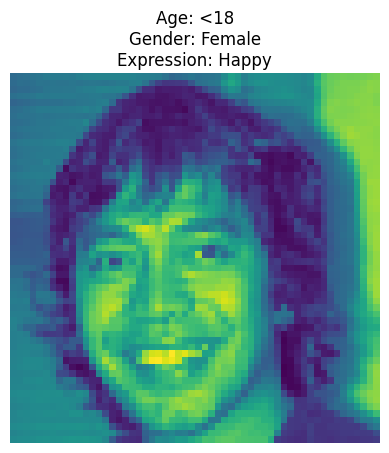

In [59]:
local_image_path = 'test/komeng_56.jpg'

# Labels
gender_labels = ['Male', 'Female']
age_labels = ['<18', '18-30', '30-50', '50+']
expression_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Make predictions for the local image
img = load_img(local_image_path, target_size=(56, 56), color_mode='grayscale')  # Adjust target_size as needed
img_array = img.resize((56, 56), Image.Resampling.LANCZOS)
img_array = np.array(img_array)
img_array = img_array.reshape(1, 56, 56, 1)
img_array = img_array/255.

# Predict gender and age
gender_pred, age_pred = agender_mlp_model.predict(img_array)
gender_pred = gender_labels[round(gender_pred[0][0])]
age_pred = age_labels[round(age_pred[0][0])]

# Predict expression
expression_pred = expression_mlp_model.predict(img_array)
expression_pred = expression_labels[np.argmax(expression_pred)]

plt.title(f'Age: {age_pred}\nGender: {gender_pred}\nExpression: {expression_pred}')
plt.axis('off')
plt.imshow(img)
plt.show()

## Evaluation

In [ ]:
# Load gender and age MLP model
agender_mlp_model = load_model("models/agender_mlp_model.keras")

In [ ]:
# Load expression MLP model
expression_mlp_model = load_model("models/expression_mlp_model.keras")

In [60]:
# Get gender and age predictions
gender_train_pred, age_train_pred = agender_mlp_model.predict(X_agender_train, verbose=0)
gender_test_pred, age_test_pred = agender_mlp_model.predict(X_agender_test, verbose=0)

In [61]:
gender_train_pred = gender_train_pred.round().flatten()
age_train_pred = age_train_pred.round().flatten()
gender_test_pred = gender_test_pred.round().flatten()
age_test_pred = age_test_pred.round().flatten()

In [65]:
# Get expression predictions
expression_train_pred = expression_mlp_model.predict(train_generator, verbose=0)
expression_test_pred = expression_mlp_model.predict(val_generator, verbose=0)

In [66]:
expression_train_pred = expression_train_pred.argmax(axis=1)
expression_test_pred = expression_test_pred.argmax(axis=1)

In [67]:
# Print report
print_report("GENDER", y_gender_train, gender_train_pred, y_gender_test, gender_test_pred)
print_report("AGE", y_age_train, age_train_pred, y_age_test, age_test_pred, multiclass=True)
print_report("EXPRESSION", train_generator.labels, expression_train_pred, val_generator.labels, expression_test_pred, multiclass=True)

----- GENDER -----
Training set
Accuracy: 0.8839502267215016
Precision: 0.8496362166531932
Recall: 0.9218287468479334
F1-score: 0.8842614502813273
Validation set
Accuracy: 0.859552931252636
Precision: 0.8176910299003323
Recall: 0.8966302367941712
F1-score: 0.8553431798436143
----- AGE -----
Training set
Accuracy: 0.5751344511230623
Precision: 0.5751344511230623
Recall: 0.5751344511230623
F1-score: 0.5751344511230623
Validation set
Accuracy: 0.5531421341206242
Precision: 0.5531421341206242
Recall: 0.5531421341206242
F1-score: 0.5531421341206242
----- EXPRESSION -----
Training set
Accuracy: 0.2485340550293189
Precision: 0.2485340550293189
Recall: 0.2485340550293189
F1-score: 0.2485340550293189
Validation set
Accuracy: 0.2584206057175205
Precision: 0.2584206057175205
Recall: 0.2584206057175205
F1-score: 0.2584206057175205
